## The Goal: Start testing out how to compute HCF 
<b>Author:</b> Meg D. Fowler<br>
<b>Date:</b> 29 Sept 2020 <br><br>

In [1]:
# Import libraries 
import comet as cm 
import numpy as np 
import xarray as xr 
import pickle
import pandas as pd
import datetime 
import datetime 
import time 

# Plotting utils 
import matplotlib.pyplot as plt 
import cartopy
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import cartopy.util


## Read in some data?

<b>What data do we need?</b> <br>
Vertical profiles of: temperature (T), specific humidity (Q), geopotential height (zg in CESM2, Z3 in other runs), and pressure (P). <br>
In addition, need lowest level temperature, specfic humidity, height, and pressure - so basically T2m, Q2m, PSfc, and 2m height. <br><br>
<b>Units:</b><br>
Temperature --> K <br>
Height      --> m <br>
Sp. Humidity -> kg/kg <br>
Pressure    --> Pa  <br><br>


Start with a focus on 1980 to test things out




In [2]:
dataDir = '/Users/mdfowler/Documents/Analysis/Coupling_initial/data/hrSim_CONUS/'

Tpr_file = dataDir+'f.e21.FHIST_BGC.f09_f09_mg17.hourlyOutput.001.cam.h1.1980_hrT-UTCsel.nc'
Zpr_file = dataDir+'f.e21.FHIST_BGC.f09_f09_mg17.hourlyOutput.001.cam.h1.1980_hrZ3-UTCsel.nc'
Qpr_file = dataDir+'f.e21.FHIST_BGC.f09_f09_mg17.hourlyOutput.001.cam.h1.1980_hrQ-UTCsel.nc'
Ppr_file = dataDir+'f.e21.FHIST_BGC.f09_f09_mg17.hourlyOutput.001.cam.h1.1979-1981_hrP-levels-UTCsel.nc'

# ----------- Open files -------------
print('Read in profile of...')
Tpr = xr.open_dataset(Tpr_file, decode_times=True)
Tpr['time'] = Tpr.indexes['time'].to_datetimeindex()
print('.....T')
Zpr = xr.open_dataset(Zpr_file, decode_times=True)
Zpr['time'] = Zpr.indexes['time'].to_datetimeindex()
print('.....Z3')
Qpr = xr.open_dataset(Qpr_file, decode_times=True)
Qpr['time'] = Qpr.indexes['time'].to_datetimeindex()
print('.....Q')
Ppr = xr.open_dataset(Ppr_file, decode_times=True)
Ppr['time'] = Ppr.indexes['time'].to_datetimeindex()
print('.....P')

# ----------- Isolate 1980 in Ppr -----
dates1980     = pd.DatetimeIndex(Tpr['time'].values)
datesPpr      = pd.DatetimeIndex(Ppr['time'].values)
iTimes        = np.where( (datesPpr>=(dates1980[0])) & (datesPpr<=dates1980[-1]) )[0]

Ppr_sel       = Ppr.isel(time=iTimes)


Read in profile of...
.....T
.....Z3
.....Q


<ipython-input-2-712b54a28809>:11: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  Tpr['time'] = Tpr.indexes['time'].to_datetimeindex()
<ipython-input-2-712b54a28809>:14: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  Zpr['time'] = Zpr.indexes['time'].to_datetimeindex()
<ipython-input-2-712b54a28809>:17: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  Qpr['t

.....P


<ipython-input-2-712b54a28809>:20: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  Ppr['time'] = Ppr.indexes['time'].to_datetimeindex()


### To make things a bit easier, assemble everything into a single dataframe, ordered with the surface level first 

In [3]:
ds_Full = Tpr 
ds_Full['Qpr'] = (('time','lev','lat','lon'), Qpr.Q)
ds_Full['Zpr'] = (('time','lev','lat','lon'), Zpr.Z3)
ds_Full['Ppr'] = (('time','lev','lat','lon'), Ppr_sel.PRESSURE)


In [4]:
# Pick out 12 UTC only 
ds_utc12 = ds_Full.where( ds_Full.UTC_hr==12.0 , drop=True )


**Pick out test location/time**

In [5]:
# Convert to dataframe for one point in space and time: 
iLat  = 10
iLon  = 30 
iTime = 10 

DF = ds_utc12.isel(lat=iLat,lon=iLon,time=iTime).to_dataframe()

# Flip order of levels so that surface comes first (required for function)
DF = DF.reindex(index=DF.index[::-1])



In [6]:
# Define length of dimensions 
nLev  = len(ds_utc12.lev)
print(nLev)


32


## Wondering about using f2py...

In [35]:
# Define variable names 
Tname = 'T'
Qname = 'Qpr'
Zname = 'Zpr'
Pname = 'Ppr'

# Profile starting at level above sfc
tmp_in   = DF[Tname].values[1::]
qhum_in  = DF[Qname].values[1::]
hgt_in   = DF[Zname].values[1::]
press_in = DF[Pname].values[1::]

# Sfc values set as first level values 
t2m      = DF[Tname].values[0]
q2m      = DF[Qname].values[0]
h2m      = DF[Zname].values[0]
psfc     = DF[Pname].values[0]

# Number of levels to worry about in actual "sounding"
nlev1 = nLev-1 

In [36]:
#--------------------------------
# Compute CTP-HiLow
#--------------------------------
from comet.metrics.fortran import hcf

TBM, BCLH, BCLP, TDEF = hcf.hcf_vars_calc.hcfcalc(nlev1,
                                                    tmp_in, 
                                                    press_in,
                                                    qhum_in, 
                                                    hgt_in, 
                                                    t2m, 
                                                    psfc,
                                                    q2m, 
                                                    h2m)


# TBM  : *** buoyant mixing pot. temp (convective threshold) [K]
# BCLH : *** height above ground of convective threshold [m]
# BCLP : *** pressure of convective threshold level [Pa]
# TDEF : *** potential temperature deficit need to initiate [K] 

# !! Note that evaluation metrics are not returned with this call. 


In [37]:
TBM

317.9294128417969

## Compute using above approach (CoMeT f2py version)

In [6]:
# Define dimensions 
nLat  = len(ds_utc12.lat)
nLon  = len(ds_utc12.lon)
nTime = len(ds_utc12.time)

In [13]:
# Define variable names 
Tname = 'T'
Qname = 'Qpr'
Zname = 'Zpr'
Pname = 'Ppr'

# Number of levels to worry about in actual "sounding"
nLev  = len(ds_utc12.lev)
nlev1 = nLev-1 

In [41]:
# Define empty arrays to save things into 
TBM_all   = np.full([nTime,nLat,nLon], np.nan)
BCLH_all  = np.full([nTime,nLat,nLon], np.nan)
BCLP_all  = np.full([nTime,nLat,nLon], np.nan)
TDEF_all  = np.full([nTime,nLat,nLon], np.nan)

# Time how long this takes... 
t_start     = time.time()


for iLat in range(nLat):
    for iLon in range(nLon):
        for iT in range(nTime):
            
            # Pick out specific point and time period 
            DF = ds_utc12.isel(lat=iLat,lon=iLon,time=iT).to_dataframe()
            
            # Flip order of levels so that surface comes first (required for function)
            DF = DF.reindex(index=DF.index[::-1])
            
            # Compute HCF variables

            TBM_all[iT,iLat,iLon], BCLH_all[iT,iLat,iLon], BCLP_all[iT,iLat,iLon], TDEF_all[iT,iLat,iLon] = hcf.hcf_vars_calc.hcfcalc(nlev1, 
                                                                                                    DF[Tname].values[1::], 
                                                                                                    DF[Pname].values[1::],
                                                                                                    DF[Qname].values[1::], 
                                                                                                    DF[Zname].values[1::], 
                                                                                                    DF[Tname].values[0], 
                                                                                                    DF[Pname].values[0],
                                                                                                    DF[Qname].values[0], 
                                                                                                    DF[Zname].values[0])
    print('Done with lat %i of %i ' % (iLat, nLat))
        

print('Time elapsed for all points and times: %.3f sec' % (time.time() - t_start))



Done with lat 0 of 43 
Done with lat 1 of 43 
Done with lat 2 of 43 
Done with lat 3 of 43 
Done with lat 4 of 43 
Done with lat 5 of 43 
Done with lat 6 of 43 
Done with lat 7 of 43 
Done with lat 8 of 43 
Done with lat 9 of 43 
Done with lat 10 of 43 
Done with lat 11 of 43 
Done with lat 12 of 43 
Done with lat 13 of 43 
Done with lat 14 of 43 
Done with lat 15 of 43 
Done with lat 16 of 43 
Done with lat 17 of 43 
Done with lat 18 of 43 
Done with lat 19 of 43 
Done with lat 20 of 43 
Done with lat 21 of 43 
Done with lat 22 of 43 
Done with lat 23 of 43 
Done with lat 24 of 43 
Done with lat 25 of 43 
Done with lat 26 of 43 
Done with lat 27 of 43 
Done with lat 28 of 43 
Done with lat 29 of 43 
Done with lat 30 of 43 
Done with lat 31 of 43 
Done with lat 32 of 43 
Done with lat 33 of 43 
Done with lat 34 of 43 
Done with lat 35 of 43 
Done with lat 36 of 43 
Done with lat 37 of 43 
Done with lat 38 of 43 
Done with lat 39 of 43 
Done with lat 40 of 43 
Done with lat 41 of 43 
Do

In [43]:
#  Save the array with TBM_all 
saveDir  = '/Users/mdfowler/Documents/Analysis/Coupling_initial/Coupling_CAM6CLM5/processed_data/'
saveFile = 'f.e21.FHIST_BGC.f09_f09_mg17.hourlyOutput.001.HCF-TBM_1980_CONUS_12utc.p' 

pickle.dump( TBM_all, open( saveDir+saveFile, "wb" ), protocol=4 )


In [44]:
#  Save the array with TBM_all 
saveDir  = '/Users/mdfowler/Documents/Analysis/Coupling_initial/Coupling_CAM6CLM5/processed_data/'
saveFile = 'f.e21.FHIST_BGC.f09_f09_mg17.hourlyOutput.001.HCF-BCLH_1980_CONUS_12utc.p' 

pickle.dump( BCLH_all, open( saveDir+saveFile, "wb" ), protocol=4 )


In [45]:
#  Save the array with TBM_all 
saveDir  = '/Users/mdfowler/Documents/Analysis/Coupling_initial/Coupling_CAM6CLM5/processed_data/'
saveFile = 'f.e21.FHIST_BGC.f09_f09_mg17.hourlyOutput.001.HCF-BCLP_1980_CONUS_12utc.p' 

pickle.dump( BCLP_all, open( saveDir+saveFile, "wb" ), protocol=4 )



In [46]:
#  Save the array with TBM_all 
saveDir  = '/Users/mdfowler/Documents/Analysis/Coupling_initial/Coupling_CAM6CLM5/processed_data/'
saveFile = 'f.e21.FHIST_BGC.f09_f09_mg17.hourlyOutput.001.HCF-TDEF_1980_CONUS_12utc.p' 

pickle.dump( TDEF_all, open( saveDir+saveFile, "wb" ), protocol=4 )


In [24]:
# Load from files 
saveDir  = '/Users/mdfowler/Documents/Analysis/Coupling_initial/Coupling_CAM6CLM5/processed_data/'

TDEF_file = saveDir+'f.e21.FHIST_BGC.f09_f09_mg17.hourlyOutput.001.HCF-TDEF_1980_CONUS_12utc.p'
TDEF_all  = pickle.load( open(TDEF_file, "rb") )

BCLP_file = saveDir+'f.e21.FHIST_BGC.f09_f09_mg17.hourlyOutput.001.HCF-BCLP_1980_CONUS_12utc.p'
BCLP_all  = pickle.load( open(BCLP_file, "rb") )

BCLH_file = saveDir+'f.e21.FHIST_BGC.f09_f09_mg17.hourlyOutput.001.HCF-BCLH_1980_CONUS_12utc.p'
BCLH_all  = pickle.load( open(BCLH_file, "rb") )

TBM_file = saveDir+'f.e21.FHIST_BGC.f09_f09_mg17.hourlyOutput.001.HCF-TBM_1980_CONUS_12utc.p'
TBM_all  = pickle.load( open(TBM_file, "rb") )


## Plot TBM
TBM is the buoyant mixing potential temperature - The theta needed to be reached if convection is to be triggered locally. 

In [6]:
np.shape(TBM_all)

(365, 43, 65)

In [7]:
# Get JJA only 
iJJA = np.where((ds_utc12.UTC_mon>=6) & (ds_utc12.UTC_mon<=8))[0]
TBM_JJA = TBM_all[iJJA,:,:]

# Average over summer 
TBM_avg = np.nanmean(TBM_JJA, axis=0)



In [8]:
lon = ds_utc12.lon.values
lat = ds_utc12.lat.values

In [10]:
import matplotlib as mpl

cmap = plt.cm.jet  # define the colormap
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]

# create the new map
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)

# define the bins and normalize
bounds = np.linspace(297, 333, 13)
norm   = mpl.colors.BoundaryNorm(bounds, cmap.N)


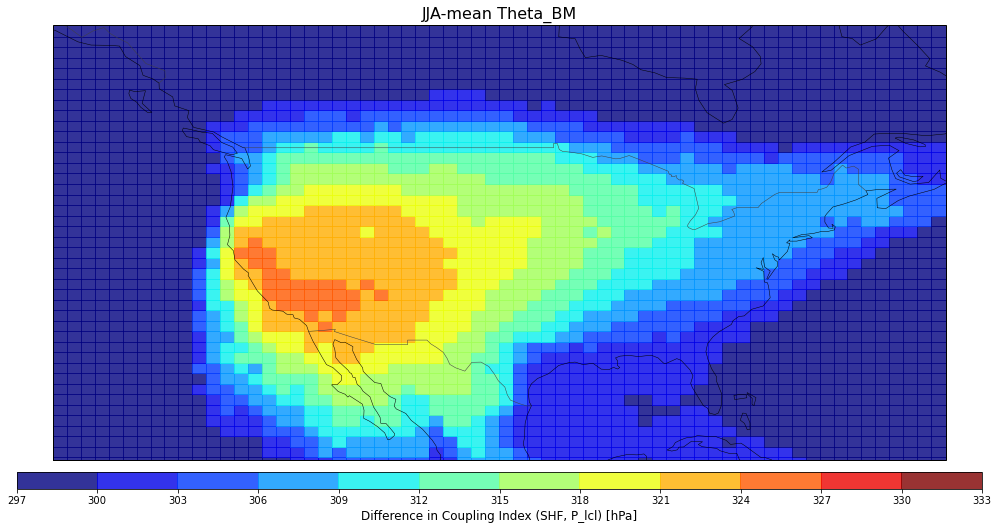

In [85]:
# Plot mean TBM 
fig, ax1 = plt.subplots(1,1, figsize=(17, 8), 
                        facecolor='w', edgecolor='k',
                        subplot_kw={'projection':ccrs.PlateCarree()})

# Zoom in on US
ax1.set_extent([-140,-60,21,60], crs=ccrs.PlateCarree())  


# ----- Plot difference from CESM1 ------ 
# Contour plots 
contour_plot = ax1.pcolormesh(lon,lat,TBM_avg,
                             alpha=0.8,
                             vmin=297,vmax=333,
                             cmap=cmap, norm=norm)

# Additional options 
ax1.set_title('JJA-mean Theta_BM',fontsize=16)
ax1.coastlines(linewidth=0.5,edgecolor='k')
ax1.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')

# Add colorbar 
ax_position = ax1.get_position()
cbar_ax = fig.add_axes([ax_position.x0-0.03, ax_position.y0-0.05, ax_position.width+0.06, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax,
                   cmap=cmap, norm=norm, ticks=bounds, boundaries=bounds)
cbar.set_label('Difference in Coupling Index (SHF, P_lcl) [hPa]',fontsize=12)



# # create a second axes for the colorbar
# cb = ax1.colorbar(cmap=cmap, norm=norm, ticks=bounds, boundaries=bounds, format='%1i')



## Use script developed below to get HCF variables

In [5]:
from ComputeHCF import HCF 

In [ ]:
# ------------------------------------------
# Compute for each day and lat/lon point
# ------------------------------------------

# Define variable names 
Tname = 'T'
Qname = 'Qpr'
Zname = 'Zpr'
Pname = 'Ppr'

# Number of levels to worry about in actual "sounding"
nLev  = len(ds_utc12.lev)

# Define dimensions 
nLat  = len(ds_utc12.lat)
nLon  = len(ds_utc12.lon)
nTime = len(ds_utc12.time)

# Define empty arrays to save things into 
TBM_all     = np.full([nTime,nLat,nLon], np.nan)
BCLH_all    = np.full([nTime,nLat,nLon], np.nan)
BCLP_all    = np.full([nTime,nLat,nLon], np.nan)
TDEF_all    = np.full([nTime,nLat,nLon], np.nan)

TRAN_H_all  = np.full([nTime,nLat,nLon], np.nan)
TRAN_P_all  = np.full([nTime,nLat,nLon], np.nan)
TRAN_T_all  = np.full([nTime,nLat,nLon], np.nan)
SHDEF_M_all = np.full([nTime,nLat,nLon], np.nan)
LHDEF_M_all = np.full([nTime,nLat,nLon], np.nan)
EADV_M_all  = np.full([nTime,nLat,nLon], np.nan)

# Time how long this takes... 
t_start     = time.time()

for iLat in range(nLat):
    for iLon in range(nLon):
        for iT in range(nTime):
            
            # Pick out specific point and time period 
            DF = ds_utc12.isel(lat=iLat,lon=iLon,time=iT).to_dataframe()
            
            # Flip order of levels so that surface comes first (required for function)
            DF = DF.reindex(index=DF.index[::-1])
            
            # Compute HCF variables

            TBM_all[iT,iLat,iLon],BCLH_all[iT,iLat,iLon],BCLP_all[iT,iLat,iLon],TDEF_all[iT,iLat,iLon],TRAN_H_all[iT,iLat,iLon],TRAN_P_all[iT,iLat,iLon],TRAN_T_all[iT,iLat,iLon],SHDEF_M_all[iT,iLat,iLon],LHDEF_M_all[iT,iLat,iLon], EADV_M_all[iT,iLat,iLon] = HCF(DF, 
                                                                      Tname, 
                                                                      Qname, 
                                                                      Zname, 
                                                                      Pname, 
                                                                      nLev) 
                                                                      
    print('Done with lat %i of %i ' % (iLat, nLat))
        

print('Time elapsed for all points and times: %.3f sec' % (time.time() - t_start))



/Users/mdfowler/Documents/Analysis/Coupling_initial/Coupling_CAM6CLM5/ComputeHCF.py:554: RuntimeWarning: invalid value encountered in greater
  iMask         = np.where((~np.isnan(xaxis1)) & (xaxis1>pthresh))[0]
/Users/mdfowler/Documents/Analysis/Coupling_initial/Coupling_CAM6CLM5/ComputeHCF.py:586: RuntimeWarning: invalid value encountered in greater
  iMask         = np.where((~np.isnan(xaxis1)) & (xaxis1>pthresh))[0]
/Users/mdfowler/Documents/Analysis/Coupling_initial/Coupling_CAM6CLM5/ComputeHCF.py:591: RuntimeWarning: invalid value encountered in less_equal
  if ( (np.all(xaxis1<=pthresh)) & (np.all(xaxis>=pbl_p)) & (np.all(np.isnan(xaxis1))) ):
/Users/mdfowler/Documents/Analysis/Coupling_initial/Coupling_CAM6CLM5/ComputeHCF.py:595: RuntimeWarning: invalid value encountered in greater
  iMask       = np.where( (xaxis1>pthresh) & (xaxis<pbl_p) & (~np.isnan(xaxis1)))[0]
/Users/mdfowler/Documents/Analysis/Coupling_initial/Coupling_CAM6CLM5/ComputeHCF.py:695: RuntimeWarning: invalid v

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

Done with lat 1 of 43 
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
Done with lat 2 of 43 
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturation profiles ============
=========== ERROR  in locating saturatio

In [9]:
iLat

0

## Start attempt to compute from scratch 

In [28]:
# -----------------------------------
#  Pick out test location 
# -----------------------------------
# Convert to dataframe for one point in space and time: 
iLat  = 0
iLon  = 50 
iTime = 103 

DF = ds_utc12.isel(lat=iLat,lon=iLon,time=iTime).to_dataframe()

# Flip order of levels so that surface comes first (required for function)
DF = DF.reindex(index=DF.index[::-1])


In [29]:
# Define variable names 
Tname = 'T'
Qname = 'Qpr'
Zname = 'Zpr'
Pname = 'Ppr'

# Profile starting at level above sfc
tmp_in   = DF[Tname].values[1::]
qhum_in  = DF[Qname].values[1::]
hgt_in   = DF[Zname].values[1::]
press_in = DF[Pname].values[1::]

# Sfc values set as first level values 
t2m      = DF[Tname].values[0]
q2m      = DF[Qname].values[0]
h2m      = DF[Zname].values[0]
psfc     = DF[Pname].values[0]

# Number of levels to worry about in actual "sounding"
nlev1 = nLev-1 


In [30]:
# -----------------------------------------------
#    Set constants 
# -----------------------------------------------
p_ref  = 1e5 
Lv     = 2.5e6 
cp     = 1005.7
R_cp   = 287.04/1005.7

grav   = 9.81 
Rd     = 287.04
pi     = np.pi
cp_g   = cp/grav
Lv_g   = Lv/grav
r2d    = 180./pi

by100  = 1e2
t0     = 273.15 
ep     = 0.622
es0    = 6.11
a      = 17.269
b      = 35.86
onemep = 1.0 - ep


In [31]:
# -----------------------------------------------
#    Initiate empty arrays 
# -----------------------------------------------
shdef = np.full([nlev1+1], np.nan)
lhdef = np.full([nlev1+1], np.nan)
eadv  = np.full([nlev1+1], np.nan)
rhoh  = np.full([nlev1+1], np.nan)
pbar  = np.full([nlev1+1], np.nan)
qdef  = np.full([nlev1+1], np.nan)
qmix  = np.full([nlev1+1], np.nan)

qsat   = np.full([nlev1+1], np.nan)
dpress = np.full([nlev1+1], np.nan) 
qbar   = np.full([nlev1+1], np.nan)
logp   = np.full([nlev1+1], np.nan)
hbar   = np.full([nlev1+1], np.nan)
tbar   = np.full([nlev1+1], np.nan)
tmp_k  = np.full([nlev1+1], np.nan)
press  = np.full([nlev1+1], np.nan)
pot_k  = np.full([nlev1+1], np.nan)
hgt    = np.full([nlev1+1], np.nan)
qhum   = np.full([nlev1+1], np.nan)

pot_diff = np.full([nlev1+1], np.nan)
eadv_0   = np.full([nlev1+1], np.nan)
xaxis    = np.full([nlev1+1], np.nan)
xaxis1   = np.full([nlev1+1], np.nan)
yaxis    = np.full([nlev1+1], np.nan)
yaxis1   = np.full([nlev1+1], np.nan)
integral = np.full([nlev1+1], np.nan)
below    = np.full([nlev1+1], np.nan)


In [32]:
# -----------------------------------------------
#    Store temp working arrays and initialize 
# -----------------------------------------------
nlev      = nlev1+1 

tmp_k[1:] = tmp_in 
hgt[1:]   = hgt_in
qhum[1:]  = qhum_in
press[1:] = press_in 

tmp_k[0] = t2m 
hgt[0]   = h2m
qhum[0]  = q2m 
press[0] = psfc


In [33]:
# ----- Run a few checks on pressure (but most of this is unfortunately on the user ) ------- 

# Check that pressure levels aren't greater than the surface pressure 
iProblem = np.where(press[1:] >= psfc)[0]

if len(iProblem)>0:
    print('***** ERROR: lowest pressure level > surface pressure *****')

# Check ordering of Plev: 
if press[0]<press[-1]:
    print('***** ERROR: pressure levels should be reversed *****') 

# Check units of pressure 
if psfc<=2000.0: 
    print('**** ERROR: pressures should be in Pa, not hPa *****') 


In much of code below, I have the calculation in .f90 from CoMeT ncl script commented out. 

In [34]:
# -----------------------------------------------
#    Compute column potential temperature 
# -----------------------------------------------
pot_k = tmp_k * (p_ref/press)**(R_cp)

# -----------------------------------------------
#    Ignore missing data levels when calculating midpoints 
#     (shouldn't be an issue for model data)
# -----------------------------------------------
hbar = hgt
pbar = press
tbar = tmp_k

# -----------------------------------------------
#    Compute middle layer specific humidity average [kg/kg]
#    1st layer = the 2m sp. humidity above, then layer averages above 
# -----------------------------------------------
qbar = qhum 
qbar[1:nlev] = ( (qhum[1:nlev]*np.log(press[1:nlev]) + 
                  qhum[0:nlev-1]*np.log(press[0:nlev-1]) )  / 
                  np.log(press[1:nlev]*press[0:nlev-1]))
# qbar(2:nlev)    = ((qhum(2:nlev  )*log(press(2:nlev  ))  + &
#                                   qhum(1:nlev-1)*log(press(1:nlev-1))) / &
#                                   log(press(2:nlev)* press(1:nlev-1)))


# -----------------------------------------------
#    Compute pressure difference of each layer 
# -----------------------------------------------
if dpress[0]<=0: 
    dpress[0] = 1.     # Set to 1 Pa because h2m is likely zero 
else:
    dpress[0]   = (psfc / (Rd * t2m * ((1. + (q2m/ep)) / (1. + q2m)) )) * grav * h2m 
    #dpress(1)  =  (psfc / (Rd * t2m * ((1. + (q2m/ep)) / (1. + q2m)) )) * grav * h2m
    
# Model data shouldn't have any missing, so not using this line:
#    where( pbar(1:nlev-1).ne.missing  .and.  pbar(2:nlev).ne.missing )
dpress[1:nlev] = press[0:nlev-1] - press[1:nlev]

# -----------------------------------------------
#    Compute log pressure to linearize it for slope calculation 
# -----------------------------------------------
logp = np.log(pbar)

# -----------------------------------------------
#    Compute mixed layer sp. humidity and column density [kg/kg]
# -----------------------------------------------
qmix = qbar * dpress/grav
rhoh = dpress/grav

for izz in range(nlev-1):
    zz = izz+1    # .f90 is: do zz = 2, nlev; so going to increase index by one 
    if (np.isfinite(qmix[zz]) & np.isfinite(qmix[zz-1])): 
        qmix[zz] = qmix[zz-1] + qmix[zz]
        
    if (np.isfinite(rhoh[zz]) & np.isfinite(rhoh[zz-1]) ):
        rhoh[zz] = rhoh[zz-1] + rhoh[zz]
        
# -----------------------------------------------
#    Compute saturation specific humidity at each level
# -----------------------------------------------
pbar = pbar/1e2
qsat = by100*0.01 *(ep* (es0*np.exp((a*( tbar-t0))/( tbar-b))) ) / (pbar-onemep*(es0*np.exp((a*( tbar-t0))/( tbar-b))))
qsat = qsat/(1.+qsat)
pbar  =  pbar*1e2

# -----------------------------------------------
#    Calculate specific humidity deficit [kg/kg]
# -----------------------------------------------
qmix = qmix / rhoh
qdef = qsat - qmix 

# -----------------------------------------------
#    Check that qdef is always negative outside of tropopause.
#    Assum tropo height of 10 km; so BCL cannot be higher 
# -----------------------------------------------
iCheck = np.where(hbar>=10000.0)[0]
qdef[iCheck] = -1.0



In [35]:
#***********************************************************
#***   Calculate slope of each variable to find the      ***
#***   y-intercept for each variable;                    ***
#***   Meaning locate the two data points surrounding    ***
#***   the sign change in qdef and linearly interpolate  ***
#***   to find the "zero point"                          ***
#***********************************************************

# -----------------------------------------------
#   Find point where sign first turns negative from the ground up
# -----------------------------------------------

# Highest unsaturated level 
num_unsat = len(np.where((np.isfinite(qdef)) & (qdef>0))[0])
if num_unsat>0: 
    # i_unsat   =   maxloc( hbar, DIM = 1, MASK = qdef.ne.missing .and. qdef.gt.0 )
    iMask       = np.where((~np.isnan(qdef)) & (qdef>0))[0]
    hbar_masked = hbar[iMask]
    i_unsat     = np.where(hbar==np.nanmax(hbar_masked))[0]
else: 
    i_unsat = 0 
    
# Lowest saturated level 
num_sat  = len(np.where((np.isfinite(qdef)) & (qdef<=0))[0])
if num_sat>0:
    #i_sat =   minloc( hbar, DIM = 1, MASK = qdef.ne.missing .and. qdef.le.0 )
    iMask  = np.where((~np.isnan(qdef)) & (qdef<=0))[0]
    hbar_masked = hbar[iMask]
    i_sat = np.where(hbar==np.nanmin(hbar_masked))[0]
else: 
    i_sat = 0 
    
# -----------------------------------------------
#  If all levels are saturated, then put the deficit to zero
# -----------------------------------------------
sat_flag = 0
if num_unsat==0: 
    pot2m = (t2m) * ((p_ref/psfc)**(R_cp))  *  (1. + 0.61*qmix[0])
    BCLP   = psfc 
    BCLH  = h2m
    TBM   = pot2m 
    TDEF  = 0.
    
    sat_flag = 1 
    print('ALL LEVELS ARE SATURATED. Returning')

# Coding now to keep computing things ONLY IF not all levels are saturated 
if sat_flag==0:
    # -----------------------------------------------
    # Check to see if first level is saturated (Foggy scenario). 
    # If yes, check 2nd and 3rd layers to see if fog will dissipate. 
    # If the 2nd and/or 3rd are not saturated, then recalculate 
    #  CONVECTIVE saturation transition level. 
    # -----------------------------------------------
    
    if ((i_sat>1) & (i_unsat>i_sat)):
        i_unsat  =  i_sat - 1
        
    if (i_sat==1): 
        cc = 0
        
        for izz in range(nlev-2):
            zz = izz+1    # .f90 is: do zz = 2, nlev-1; so going to increase index by one 
            
            # Make sure initiation level is below 100 hPa above the ground 
            #      to ensure it is actually fog. 
            if ( ((psfc-pbar[zz])/1e2) > 100 ):   # if( (psfc-pbar(zz))/1e2.gt.100 ) exit
                break 
            
            # If it *is* within 100 hPa layer above ground, try to erode fog layer first
            #   to determine convective initiation layer 
            # i_sat  =  minloc( hbar(zz:), DIM = 1, MASK = qdef(zz:).ne.missing .and. qdef(zz:).le.0 )
            hbar_mask1  = hbar[zz:]
            iMask       = np.where((np.isfinite(qdef[zz:])) & (qdef[zz:]<=0))[0]
            hbar_masked = hbar_mask1[iMask]
            i_sat       = np.where(hbar_mask1==np.nanmin(hbar_masked))[0] 
            
            cc = cc + 1
            
            # If still saturated then cycle 
            if i_sat==1:
                continue 
            i_sat = i_sat + cc 
            break 
        i_unsat = i_sat - 1 
    
    # -----------------------------------------------
    # If all layers below 100 hPa above ground are still saturated, 
    # call it all saturated and use 1st level stats and call it "convective"
    # b/c fog is unlikely to be deeper than 100 hPa above ground 
    # -----------------------------------------------
    
    if i_unsat==0: 
        pot2m = (t2m) * ((p_ref/psfc)**(R_cp))  *  (1. + 0.61*qmix[0])
        BCLP  = psfc
        BCLH  = h2m 
        TBM   = pot2m 
        TDEF  = 0. 
        
        sat_flag = 1 
        print('ALL LEVELS ARE SATURATED. Returning')
        
    # -----------------------------------------------
    # Check to make sure these are adjacent layers 
    # If not, there's a problem. 
    # -----------------------------------------------
    if ((i_unsat==0) | (i_sat==0)):
        print('=========== ERROR  in locating saturation profiles ============')
        sat_flag=1 
        pot2m = np.nan
        BCLP  = np.nan
        BCLH  = np.nan
        TBM   = np.nan
        TDEF  = np.nan
        print('   Terminating program. DO NOT USE OUTPUT  ')
        
            
# Check again to make sure we shouldn't be stopping here...
if sat_flag==0: 
    # ----------------------------------------------- 
    # Get upper and lower bounds for each var to be 
    #   computed at the BCL 
    # -----------------------------------------------
    p_up        =  logp[i_sat]
    t_up        =  tbar[i_sat]
    h_up        =  hbar[i_sat]
    q_up        =  qdef[i_sat]
    m_up        =  qmix[i_sat]

    p_lo        =  logp[i_unsat]
    t_lo        =  tbar[i_unsat]
    h_lo        =  hbar[i_unsat]
    q_lo        =  qdef[i_unsat]
    m_lo        =  qmix[i_unsat]
    
    
    # -----------------------------------------------
    # Calculate output variables: BCL height, pressure, 
    #   buoyant mixing potential temp, and potential temp 
    #   deficit. 
    # -----------------------------------------------
    BCLP = np.exp( p_up - ((p_up-p_lo)/(q_up-q_lo))*q_up )
    BCLH = ( h_up - ((h_up-h_lo)/(q_up-q_lo))*q_up )
    qbcl = ( m_up - ((m_up-m_lo)/(q_up-q_lo))*q_up )
    TBM  = ( t_up - ((t_up-t_lo)/(q_up-q_lo))*q_up )* ((p_ref/BCLP)**(R_cp))
    
    # -----------------------------------------------
    # Calculate virtual potential temperature (K) using mixed humidity. 
    # NOTE: This is an assumption; only influences TDEF but 
    #   an important effect because if pot2m is close to TBM, then a slight 
    #   change in qbcl can mean the difference betwen initiation (TDEF=0)
    #   or not. Should only be an issue over very shallow PBLs.
    # -----------------------------------------------
    pot2m  =  (t2m) * ((p_ref/psfc)**(R_cp))  *  (1. + 0.61*qbcl)
    TDEF   =  TBM  - pot2m
    if TDEF<0: 
        TDEF=0 
    

In [36]:
sat_flag

0

In [37]:
print('TBM from CoMeT:  ', TBM_all[iTime,iLat,iLon])
print('TDEF from CoMeT: ', TDEF_all[iTime,iLat,iLon])

TBM from CoMeT:   nan
TDEF from CoMeT:  nan


In [38]:
print('TBM calculed here:    ', TBM)
print('TDEF calculated here: ', TDEF)

TBM calculed here:     [299.88687298]
TDEF calculated here:  [0.00144692]


In [39]:
#****************************************************
#***           ENERGY DEFICIT SECTION             ***
#****************************************************
# Takes BCL and TBM tthreshold to estimate sensible 
#   and latent heat energy [J/m2] necessary for 
#   initiating convection. Does not discriminate 
#   between shallow or deep convection. Also outputs
#   potential temperature, pressure, and height of the
#   transition from latent heat to sensible heat 
#   advantage. If there is no transition then transition
#   levels are set to NaN (missing values). 
# ----------------------------------------------------

# Handle case where there are no energy deficits, 
#  because threshold already reached (convection initiated)
if TDEF<=0: 
    SHDEF_M    =  0.
    LHDEF_M    =  0.
    EADV_M     =  np.nan
    TRAN_T     =  np.nan
    TRAN_P     =  np.nan
    TRAN_H     =  np.nan
    # End program here 
    sat_flag=1 
    print('Saturation threshold already reached! Ending program.')

# Check again to make sure we shouldn't be stopping here...
if sat_flag==0: 
    # -----------------------------------------------
    #  Find pressure level and mixed specific humidity 
    #    deficit given a potential temperature. 
    # -----------------------------------------------
    pbl_pot = pot2m 
    
    # Difference between reference potential temperature [K]
    # where( pot_k.ne.missing .and. press.ne.missing .and. tmp_k.gt.0 )   pot_diff  =  pbl_pot - pot_k
    iCalc = np.where(tmp_k>0)[0]
    pot_diff[iCalc]  =  pbl_pot  - pot_k[iCalc] 

    #***********************************************************
    #***   Calculate slope of each variable to find the      ***
    #***   y-intercept for each variable;                    ***
    #***   Meaning locate the two data points surrounding    ***
    #***   the sign change in qdef and linearly interpolate  ***
    #***   to find the "zero point"                          ***
    #***********************************************************
    
    # -----------------------------------------------
    # Find point where sign first turns negative from ground up 
    # -----------------------------------------------
    
    # Highest buoyant level 
    num_buoy = len(np.where(np.isfinite(pot_diff) & (pot_diff>0) )[0])
    if num_buoy>0: 
        # i_buoy   =   minloc( pbar, DIM = 1, MASK = pot_diff.ne.missing .and. pot_diff.gt.0 )
        iMask       = np.where( (~np.isnan(pot_diff)) & (pot_diff>0) )[0]
        pbar_masked = pbar[iMask]
        i_buoy      = np.where(pbar==np.min(pbar_masked))[0]
    else:
        i_buoy = 0
        
    # Lowest negatively buoyant level 
    num_nobuoy = len(np.where(np.isfinite(pot_diff) & (pot_diff<=0) )[0])
    if num_nobuoy>0: 
        # i_nobuoy =   maxloc( pbar, DIM = 1, MASK = pot_diff.ne.missing .and. pot_diff.le.0 )
        iMask = np.where( (~np.isnan(pot_diff)) & (pot_diff<=0))[0]
        pbar_masked = pbar[iMask]
        i_nobuoy = np.where(pbar==np.max(pbar_masked))[0]
    else:
        i_nobuoy = -1    # MDF: Set to -1 instead of 0, since 0 is first index in Py (but not F90)
    
    # -----------------------------------------------
    #  Check to make sure not all layers are buoyant (not physical)
    # -----------------------------------------------
    if i_nobuoy==-1: 
        print('=========== ERROR  in locating saturation profiles ============')
        sat_flag = 1 
        print('   Terminating program. DO NOT USE OUTPUT  ')
        
# Check again that it's safe to keep computing...
if sat_flag==0:
    # -----------------------------------------------
    #  Check to see if first level is NOT buoyant 
    #  If so, thermally produced PBL is below the first layer
    # -----------------------------------------------
    if i_nobuoy==0: 
        i_nobuoy = 1    # MDF: Set to 1 insetad of 2 (python vs. F90 indexing)
        i_buoy   = 0    # MDF: Set to 0 instead of 1 (python vs. F90 indexing)
    
    # -----------------------------------------------
    # Get upper/lower bounds for each variable to be 
    #   computed at the BCL
    # -----------------------------------------------
    p_up        =  logp    [i_nobuoy]
    q_up        =  qdef    [i_nobuoy]
    t_up        =  pot_diff[i_nobuoy]
    p_lo        =  logp    [i_buoy]
    q_lo        =  qdef    [i_buoy]
    t_lo        =  pot_diff[i_buoy]
    
    # -----------------------------------------------
    #  Calculate output variables 
    # -----------------------------------------------
    pbl_p     =  np.exp( p_up - ((p_up-p_lo)/(t_up-t_lo))*t_up )
    pbl_qdef  =        ( q_up - ((q_up-q_lo)/(t_up-t_lo))*t_up )
    
    # -----------------------------------------------
    #  Initialize energy deficit working variables 
    # -----------------------------------------------
    #shdef  = np.nan
    #lhdef  = np.nan
    #eadv   = np.nan
    #eadv_0 = np.nan
    
    # -----------------------------------------------
    #  Make sure pressure of PBL is above lowest level 
    #  This can occur for very shallow BL, and is likely
    #    due to mixing assumptions made in the BL calculation,
    #    where it is assumed to be thermally driven. 
    #  In this case, we assume the mixed layer is between
    #    the surface adn the first atmospheric model level
    # -----------------------------------------------
    if pbl_p>psfc: 
        pbl_p = psfc - (psfc-press[1])/2.0    # MDF: Index with 1 instead of 2 (py v. F90)
        
        
    #*************************************************
    #********                                 ********
    #********         --Section--             ********
    #********  Sensible Heat Deficit [J/m2]   ********
    #********                                 ********
    #*************************************************
    xaxis   =   press 
    yaxis   =   pot_k
    pthresh =   BCLP
    tthresh =   TBM

    #yaxis1  =   np.nan   # Already initialized to missing 
    #xaxis1  =   np.nan
    yaxis1[:nlev-1]  =  yaxis[1:nlev]
    xaxis1[:nlev-1]  =  xaxis[1:nlev]
    
    # -----------------------------------------------
    #  Calculate integrals from mixed layer down and up
    # -----------------------------------------------
    
    # Deficit for each layer 
    
    # itop    =   minloc( xaxis1,  DIM = 1, MASK = xaxis1.gt.pthresh .and. xaxis1.ne.missing )
    iMask         = np.where((~np.isnan(xaxis1)) & (xaxis1>pthresh))[0]
    xaxis1_masked = xaxis1[iMask]
    itop          = int(np.where(xaxis1==np.nanmin(xaxis1_masked))[0])
    ibot          = 0 
    nbot          = itop - ibot + 1
    if np.isfinite(psfc):
        total = (cp_g)  *  tthresh  *  (psfc - pthresh)
    
    integral[0] = 0.0
    below[0]    = 0.0 
    if itop==ibot:
        #---- Case where BCL is within the first layer (i.e. between 1st and 2nd index)
        # between =   (cp_g)  *  0.5*(yaxis(1)+tthresh)  *  (xaxis (1)-pthresh)
        between =   (cp_g)  *  0.5*(yaxis[0]+tthresh)  *  (xaxis[0]-pthresh)
    else:
        between =   (cp_g)  *  0.5*(yaxis1[itop]+tthresh)  *  (xaxis1[itop]-pthresh)
        
        
        # MDF: Defining array of levels to care about
        zz_levs = np.arange(ibot,itop,1).astype(int)
        
        # do zz=ibot,itop
        for izz in range(len(zz_levs)):
            zz = zz_levs[izz]
            integral[zz]    =  np.sum(  (cp_g)  *  0.5*(yaxis[zz:itop]+yaxis1[zz:itop])  * 
                                      (xaxis[zz:itop]-xaxis1[zz:itop]) )
            below   [zz+1]  =  (cp_g)  *  yaxis[zz+1]    *  (xaxis[ibot] - xaxis[zz+1])
        
    # -----------------------------------------------
    #  Deficit for mixed layer only 
    # -----------------------------------------------
    # itop    =   minloc( xaxis1,  DIM = 1,  MASK = xaxis1.gt.pthresh  .and.  xaxis1.ne.missing )
    iMask         = np.where((~np.isnan(xaxis1)) & (xaxis1>pthresh))[0]
    xaxis1_masked = xaxis1[iMask]
    itop          = int(np.where(xaxis1==np.nanmin(xaxis1_masked))[0])
        
    # if(  all(.not.(xaxis1.gt.pthresh  .and.  xaxis.lt.pbl_p   .and.  xaxis1.ne.missing))  )  then
    if ( (np.all(xaxis1<=pthresh)) & (np.all(xaxis>=pbl_p)) & (np.all(np.isnan(xaxis1))) ):
        ibot = itop 
    else: 
        # ibot = maxloc( xaxis1,  DIM = 1,  MASK = xaxis1.gt.pthresh  .and.  xaxis.lt.pbl_p   .and.  xaxis1.ne.missing )
        iMask       = np.where( (xaxis1>pthresh) & (xaxis<pbl_p) & (~np.isnan(xaxis1)))[0]
        # MDF: Adding catch for if no cases meet mask criteria:
        if len(iMask>0):
            xaxis1_mask = xaxis1[iMask]
            ibot        = int(np.where(xaxis1==np.nanmax(xaxis1_mask))[0])
        else:
            ibot = itop 
        
    nbot    =   itop - ibot + 1
    itop0   =   int(itop)
    ibot0   =   int(ibot)
    
    integral0 = 0.0
    below0    = 0.0
    if itop==ibot: 
        # ---- Case where BCL is within the first layer (i.e. between 1st and 2nd index)
        between0  =   (cp_g)  *  0.5*(pbl_pot+tthresh)  *  (pbl_p  -  pthresh)
        below0    =   (cp_g)  *  pbl_pot                *  (psfc   -  pbl_p  )
        if between0<0:
            between0  =  0.0
    else:
        #*** explicit layer and BCL
        between0   =           (cp_g) * 0.5*(yaxis1[itop] + tthresh) *  (xaxis1[itop] - pthresh)
        integral0  =   np.sum( (cp_g) * 0.5*(yaxis[ibot:itop] + yaxis1[ibot:itop])  *  (xaxis[ibot:itop] - xaxis1[ibot:itop]) )
        #*** explicit layer and PBL
        between0   =   between0  +  ((cp_g)  *  0.5*(yaxis[ibot] + pbl_pot) * (pbl_p  - xaxis [ibot]))
        below0     =                 (cp_g)  *  pbl_pot *  (psfc - pbl_p)
        
    # -----------------------------------------------
    #   Calculate the Sensible Heat Deficit [J/m2]
    #   Equation: 
    #     SHDEF = Energy from BCL to surface (scalar --> Total) MINUS
    #             the progressive integral from mixed layer
    #               to last resolved level directly below the BCL (nlev --> Integral) MINUS
    #             the energy btw last resolved level and BCL (scalar --> Between) MINUS
    #             the energy from the mixed layer to the surface (nlev --> Below)
    #   NOTE: Sensible heat deficit is calculated from the first layer to the BCL 
    # -----------------------------------------------
    shdef   =   total  -  integral  -  between  -  below
    iCheck  = np.where( (press<BCLP) | (np.isnan(press)) )[0]
    shdef[iCheck] = 0.0
    SHDEF_M   =   total  -  integral0  -  between0  -  below0
    
        
        
    #*************************************************
    #********                                 ********
    #********         --Section--             ********
    #********   Latent Heat Deficit [J/m2]    ********
    #********                                 ********
    #*************************************************
    
    # -----------------------------------------------
    #  Make sure qdef at PBLH > 0 
    #  Occurs when PBL really close (probably too close to be ignored 
    #     as not having convection). 
    #  For practical purposes, if TDEF/=0 then there is no convection, 
    #     so QDEF at PBL as estimated should also be >0. So here, 
    #     we set PBL qdef = some small number > 0 
    # -----------------------------------------------
    if pbl_qdef<0:
        pbl_qdef = 0.00001
        
    # -----------------------------------------------
    #  Calculate the Latent Heat Deficit [J/m2]
    #  Equation: 
    #    LHdef = latent heat of vaporization/gravity TIMES 
    #            pressure difference mixed layer down TIMES 
    #            Specific Humidity Deficit
    #  NOTE: Latent heat deficit is calculated from 1st layer to BCL 
    # -----------------------------------------------
    iCompute        = np.where((qdef>0) & (~np.isnan(qdef)))[0]
    lhdef[iCompute] = Lv_g  *  qdef[iCompute]  *  dpress[iCompute]
    
    iZero           = np.where((press<BCLP) | (np.isnan(press)))[0]
    lhdef[iZero]    = 0 
    
    if psfc-pbl_p<=0: 
        LHDEF_M   =   Lv_g  *  pbl_qdef  *  (dpress[0])
    else: 
        LHDEF_M   =   Lv_g  *  pbl_qdef  *  (psfc - pbl_p)
    
    
    #*************************************************
    #********                                 ********
    #********         --Section--             ********
    #********   Energy Advantage and 45deg    ********
    #********                                 ********
    #*************************************************
    iCompute       = np.where((~np.isnan(lhdef)) & (~np.isnan(shdef)) & (lhdef!=0) & (shdef!=0))[0]
    eadv[iCompute] = np.arctan2(lhdef[iCompute], shdef[iCompute]) * r2d
    
    if ((LHDEF_M>0) & (SHDEF_M>0)): 
        EADV_M = np.arctan2(LHDEF_M, SHDEF_M) * r2d
    else: 
        EADV_M = np.nan
        
    #*************************************************
    #  Special no transition case 
    #*************************************************
    if ( (np.all(np.isnan(eadv))) | (np.all(eadv<45)) | (np.all(np.isnan(eadv))) | (np.all(eadv>45)) ):
        TRAN_P  =  np.nan
        TRAN_T  =  np.nan
        TRAN_H  =  np.nan
        
        print(' ***** NO TRANSITION IS PRESENT. RETURNING. *****')
        sat_flag = 1

# Continue with calculations if appropriate
if sat_flag==0:
    # -----------------------------------------------
    #  Find where energy advantage = 45 degrees 
    #  If it doesn't occur anywhere, set all values to mising 
    # -----------------------------------------------
    iCheck         = np.where(~np.isnan(eadv))[0]
    eadv_0[iCheck] = eadv[iCheck] - 45.0
    
    # ibefore =  maxloc( hgt, DIM = 1,  MASK = eadv_0.le.0  .and.  eadv_0.ne.missing )  !location right before transition
    iMask    = np.where((eadv_0<=0) & (~np.isnan(eadv_0)))[0]
    if len(iMask>0):
        hgt_mask = hgt[iMask]
        ibefore  = np.where(hgt==np.nanmax(hgt_mask))[0]
    else: 
        ibefore = -1
    
    # iafter  =  minloc( hgt, DIM = 1,  MASK = eadv_0.gt.0  .and.  eadv_0.ne.missing )  !location right after transition
    iMask    = np.where((eadv_0>0) & (~np.isnan(eadv_0)))[0]
    if len(iMask>0):
        hgt_mask = hgt[iMask]
        iafter   = np.where(hgt==np.nanmin(hgt_mask))[0] 
    else:
        iafter = -1 
        
    #************************************
    #**** special no transition case ****
    #************************************
    if ( (iafter==-1) | (ibefore==-1) ):
        TRAN_P  =  np.nan
        TRAN_T  =  np.nan
        TRAN_H  =  np.nan
        
        print(' ***** NO TRANSITION IS PRESENT. RETURNING. *****')
        sat_flag = 1

# Check that we should still be computing things: 
if sat_flag==0:
    
    #*******************************************************************************
    #**** linear interpolation to find temp, height, and pressure of transition ****
    #*******************************************************************************
    x_hi    =  eadv_0[iafter]
    x_lo    =  eadv_0[ibefore]
    y_hi    =  np.log(press[iafter])
    y_lo    =  np.log(press[ibefore])
    TRAN_P  =  np.exp(  y_hi -  (((y_hi-y_lo)/(x_hi-x_lo)) * x_hi) )

    y_hi    =  pot_k[iafter]
    y_lo    =  pot_k[ibefore]
    TRAN_T  =  y_hi -  (((y_hi-y_lo)/(x_hi-x_lo)) * x_hi)

    y_hi    =  hgt[iafter]
    y_lo    =  hgt[ibefore]
    TRAN_H  =  y_hi -  (((y_hi-y_lo)/(x_hi-x_lo)) * x_hi)
    
    print('**** DONE WITH HCF CACLULATIONS *****')
        

 ***** NO TRANSITION IS PRESENT. RETURNING. *****


<ipython-input-39-9d961a87092f>:150: RuntimeWarning: invalid value encountered in greater
  iMask         = np.where((~np.isnan(xaxis1)) & (xaxis1>pthresh))[0]
<ipython-input-39-9d961a87092f>:182: RuntimeWarning: invalid value encountered in greater
  iMask         = np.where((~np.isnan(xaxis1)) & (xaxis1>pthresh))[0]
<ipython-input-39-9d961a87092f>:187: RuntimeWarning: invalid value encountered in less_equal
  if ( (np.all(xaxis1<=pthresh)) & (np.all(xaxis>=pbl_p)) & (np.all(np.isnan(xaxis1))) ):
<ipython-input-39-9d961a87092f>:191: RuntimeWarning: invalid value encountered in greater
  iMask       = np.where( (xaxis1>pthresh) & (xaxis<pbl_p) & (~np.isnan(xaxis1)))[0]
<ipython-input-39-9d961a87092f>:291: RuntimeWarning: invalid value encountered in less
  if ( (np.all(np.isnan(eadv))) | (np.all(eadv<45)) | (np.all(np.isnan(eadv))) | (np.all(eadv>45)) ):
<ipython-input-39-9d961a87092f>:291: RuntimeWarning: invalid value encountered in greater
  if ( (np.all(np.isnan(eadv))) | (np.all(e

In [40]:
EADV_M

nan

In [35]:
xaxis<pbl_p

array([False, False, False, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True])

In [32]:
pthresh

array([91447.7804883])